In [1]:
%%capture
!pip install mediapipe

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [3]:
!unzip /content/AFLW2000-3D.zip

Archive:  /content/AFLW2000-3D.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/image00002.jpg  
  inflating: AFLW2

In [4]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

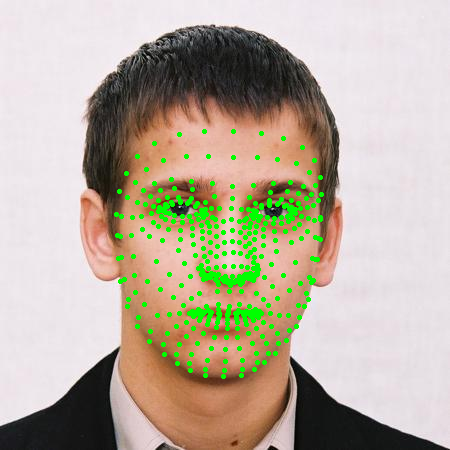

In [5]:
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

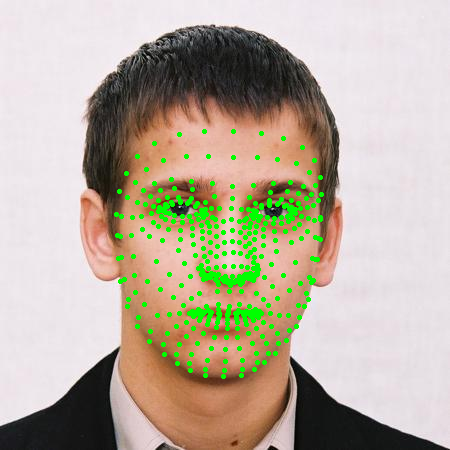

In [6]:


faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image

    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

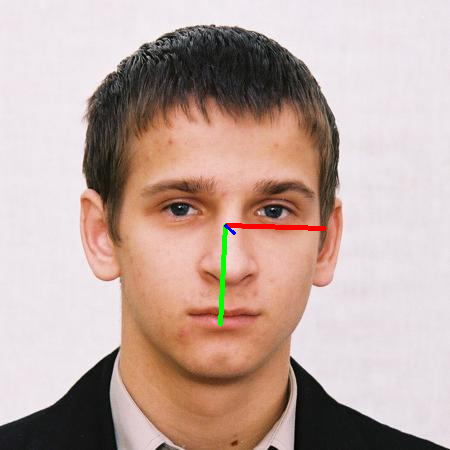

In [7]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

In [8]:
import os
import cv2
import mediapipe as mp
import pandas as pd
import scipy.io as sio

# Path to the directory containing images
directory_path = '/content/AFLW2000/'

# Initialize face mesh module
mp_face_mesh = mp.solutions.face_mesh
faceModule = mp_face_mesh.FaceMesh(static_image_mode=True)

# Function to extract landmark points from an image
def extract_landmarks(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image {image_path}")
        return None

    # Process the face to extract landmark points
    results = faceModule.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    landmarks = []

    if results.multi_face_landmarks is not None:
        # Loop over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                landmarks.append((x, y))

        # Calculate noise
        x4, y4 = landmarks[4]
        noise = {'X4': x4, 'Y4': y4}

        # Calculate distance for normalization
        x152, y152 = landmarks[152]
        distance = math.sqrt((x4 - x152)**2 + (y4 - y152)**2)

        # Normalize landmarks
        normalized_landmarks = []
        for x, y in landmarks:
            normalized_x = (x - x4) / distance
            normalized_y = (y - y4) / distance
            normalized_landmarks.append((normalized_x, normalized_y))

        return normalized_landmarks, noise
    else:
        print(f"No face detected in {image_path}")
        return None, None

# Initialize an empty DataFrame
columns = ['Image']
for i in range(0,468):
  columns.extend([f"X_{i}",f"Y_{i}"])
data = pd.DataFrame(columns=columns + ['Noise_X4', 'Noise_Y4', 'Pitch', 'Yaw', 'Roll'])

# Iterate over all files in the directory
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        image_path = os.path.join(directory_path, filename)
        print(f"Processing image: {image_path}")
        landmarks, noise = extract_landmarks(image_path)
        if landmarks is not None:
            # Flatten the list of landmarks
            flattened_landmarks = [coord for landmark in landmarks for coord in landmark]

            # Load the corresponding .mat file
            mat_file_path = os.path.join(directory_path, f"{os.path.splitext(filename)[0]}.mat")
            mat_file = sio.loadmat(mat_file_path)
            pose_para = mat_file["Pose_Para"][0][:3]
            pitch, yaw, roll = pose_para

            # Append the image filename, landmarks, noise, and pose parameters to the DataFrame
            data = data.append({'Image': filename, **{f'X_{i}': coord[0] for i, coord in enumerate(landmarks)},
                               **{f'Y_{i}': coord[1] for i, coord in enumerate(landmarks)},
                               'Noise_X4': noise['X4'], 'Noise_Y4': noise['Y4'],
                               'Pitch': pitch, 'Yaw': yaw, 'Roll': roll}, ignore_index=True)

# Close face mesh module
faceModule.close()

# Save the DataFrame to a CSV file
data.to_csv('data.csv', index=False)


Processing image: /content/AFLW2000/image00002.jpg
Processing image: /content/AFLW2000/image00004.jpg
Processing image: /content/AFLW2000/image00006.jpg
Processing image: /content/AFLW2000/image00008.jpg
Processing image: /content/AFLW2000/image00010.jpg
No face detected in /content/AFLW2000/image00010.jpg
Processing image: /content/AFLW2000/image00013.jpg
Processing image: /content/AFLW2000/image00014.jpg
Processing image: /content/AFLW2000/image00019.jpg
Processing image: /content/AFLW2000/image00020.jpg
Processing image: /content/AFLW2000/image00021.jpg
Processing image: /content/AFLW2000/image00022.jpg
Processing image: /content/AFLW2000/image00023.jpg
Processing image: /content/AFLW2000/image00026.jpg
Processing image: /content/AFLW2000/image00028.jpg
Processing image: /content/AFLW2000/image00032.jpg
No face detected in /content/AFLW2000/image00032.jpg
Processing image: /content/AFLW2000/image00035.jpg
Processing image: /content/AFLW2000/image00036.jpg
No face detected in /conten

In [9]:
data.set_index('Image', inplace=True)

In [10]:
data

,X_0,Y_0,X_1,Y_1,X_2,Y_2,X_3,Y_3,X_4,Y_4,...,Y_465,X_466,Y_466,X_467,Y_467,Noise_X4,Noise_Y4,Pitch,Yaw,Roll
Image,,,,,,,,,,,,,,,,,,,,,
image00002.jpg,-0.023766,0.318033,-0.006607,0.089623,-0.003661,0.126111,-0.052436,-0.284171,0.0,0.0,...,-0.585163,0.847951,-0.725764,0.898419,-0.761263,0.490558,0.621213,-0.399231,0.018227,0.085676
image00004.jpg,0.135390,0.342489,0.007973,0.080386,0.173977,0.176596,0.106425,-0.167740,0.0,0.0,...,-0.326326,0.887145,-0.403468,0.937679,-0.429012,0.415757,0.576966,0.470065,1.189533,0.300959
image00006.jpg,-0.034451,0.295173,-0.001236,0.081678,-0.029573,0.134064,-0.097803,-0.205510,0.0,0.0,...,-0.418426,0.488717,-0.515062,0.528595,-0.545855,0.321459,0.767816,-0.184650,0.881137,-0.236852
image00008.jpg,0.206938,0.278244,0.038110,0.079997,0.136178,0.103737,-0.085015,-0.232270,0.0,0.0,...,-0.583820,0.656938,-0.893207,0.691559,-0.947129,0.461756,0.637613,-0.175379,0.299208,-0.373374
image00013.jpg,0.088346,0.338087,0.018155,0.080560,0.046324,0.159416,-0.083512,-0.169726,0.0,0.0,...,-0.368888,0.458136,-0.529165,0.493518,-0.545693,0.488200,0.584701,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
image04345.jpg,-0.099509,0.382300,-0.012532,0.091444,-0.082647,0.161951,-0.118476,-0.237458,0.0,0.0,...,-0.495524,0.468628,-0.638928,0.502156,-0.664404,0.535343,0.607497,-0.306358,-0.283822,0.038554
image04348.jpg,-0.114418,0.343310,-0.014925,0.089406,-0.089373,0.143153,-0.106608,-0.248062,0.0,0.0,...,-0.510105,0.424913,-0.634097,0.461928,-0.675651,0.568493,0.616073,-0.367547,-0.429723,0.122791
image04356.jpg,-0.100844,0.302607,-0.022521,0.075017,-0.068619,0.153835,-0.028862,-0.183603,0.0,0.0,...,-0.299684,0.540394,-0.272573,0.580638,-0.305275,0.609593,0.610428,-0.156035,0.567114,-0.108536


In [11]:
data.loc[data.index == 'image03233.jpg']

,X_0,Y_0,X_1,Y_1,X_2,Y_2,X_3,Y_3,X_4,Y_4,...,Y_465,X_466,Y_466,X_467,Y_467,Noise_X4,Noise_Y4,Pitch,Yaw,Roll
Image,,,,,,,,,,,,,,,,,,,,,
image03233.jpg,-0.119388,0.35505,-0.005518,0.079,-0.124244,0.170148,-0.161608,-0.163452,0.0,0.0,...,-0.33001,0.176409,-0.405219,0.205258,-0.445607,0.56241,0.562853,0.036318,-0.447323,-0.115917


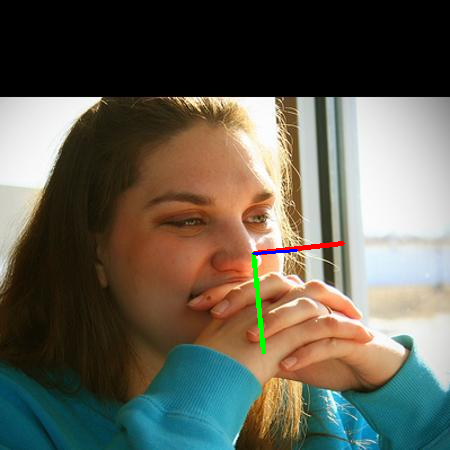

In [12]:
image = cv2.imread('/content/AFLW2000/image03233.jpg')
pitch = float(data.loc[data.index == 'image03233.jpg', 'Pitch'])
yaw = float(data.loc[data.index == 'image03233.jpg', 'Yaw'])
roll = float(data.loc[data.index == 'image03233.jpg', 'Roll'])
noise_x = float(data.loc[data.index == 'image03233.jpg', 'Noise_X4']) * image.shape[1]
noise_y = float(data.loc[data.index == 'image03233.jpg', 'Noise_Y4']) * image.shape[0]
# print(data[4,-3])
cv2_imshow(draw_axis(image,pitch,yaw,roll,noise_x,noise_y))

In [13]:
features = data.drop(columns=['Pitch', 'Yaw', 'Roll'])
labels = data[['Pitch', 'Yaw', 'Roll']]

In [14]:
features=features.drop(columns=['Noise_X4', 'Noise_Y4'])

In [15]:
features

,X_0,Y_0,X_1,Y_1,X_2,Y_2,X_3,Y_3,X_4,Y_4,...,X_463,Y_463,X_464,Y_464,X_465,Y_465,X_466,Y_466,X_467,Y_467
Image,,,,,,,,,,,,,,,,,,,,,
image00002.jpg,-0.023766,0.318033,-0.006607,0.089623,-0.003661,0.126111,-0.052436,-0.284171,0.0,0.0,...,0.334869,-0.658936,0.280270,-0.621764,0.246334,-0.585163,0.847951,-0.725764,0.898419,-0.761263
image00004.jpg,0.135390,0.342489,0.007973,0.080386,0.173977,0.176596,0.106425,-0.167740,0.0,0.0,...,0.561180,-0.368172,0.502940,-0.343096,0.446485,-0.326326,0.887145,-0.403468,0.937679,-0.429012
image00006.jpg,-0.034451,0.295173,-0.001236,0.081678,-0.029573,0.134064,-0.097803,-0.205510,0.0,0.0,...,0.121871,-0.470623,0.083497,-0.441704,0.067555,-0.418426,0.488717,-0.515062,0.528595,-0.545855
image00008.jpg,0.206938,0.278244,0.038110,0.079997,0.136178,0.103737,-0.085015,-0.232270,0.0,0.0,...,0.224828,-0.670657,0.176554,-0.623308,0.141488,-0.583820,0.656938,-0.893207,0.691559,-0.947129
image00013.jpg,0.088346,0.338087,0.018155,0.080560,0.046324,0.159416,-0.083512,-0.169726,0.0,0.0,...,0.129485,-0.412059,0.090370,-0.385039,0.070019,-0.368888,0.458136,-0.529165,0.493518,-0.545693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
image04345.jpg,-0.099509,0.382300,-0.012532,0.091444,-0.082647,0.161951,-0.118476,-0.237458,0.0,0.0,...,0.069188,-0.551927,0.032662,-0.521384,0.023654,-0.495524,0.468628,-0.638928,0.502156,-0.664404
image04348.jpg,-0.114418,0.343310,-0.014925,0.089406,-0.089373,0.143153,-0.106608,-0.248062,0.0,0.0,...,0.063322,-0.572256,0.034897,-0.538985,0.030157,-0.510105,0.424913,-0.634097,0.461928,-0.675651
image04356.jpg,-0.100844,0.302607,-0.022521,0.075017,-0.068619,0.153835,-0.028862,-0.183603,0.0,0.0,...,0.235679,-0.317604,0.193756,-0.308145,0.170728,-0.299684,0.540394,-0.272573,0.580638,-0.305275


In [16]:
labels

,Pitch,Yaw,Roll
Image,,,
image00002.jpg,-0.399231,0.018227,0.085676
image00004.jpg,0.470065,1.189533,0.300959
image00006.jpg,-0.184650,0.881137,-0.236852
image00008.jpg,-0.175379,0.299208,-0.373374
image00013.jpg,-0.026812,0.011965,-0.220662
...,...,...,...
image04345.jpg,-0.306358,-0.283822,0.038554
image04348.jpg,-0.367547,-0.429723,0.122791
image04356.jpg,-0.156035,0.567114,-0.108536


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=100)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=100)


In [18]:
y_val

,Pitch,Yaw,Roll
Image,,,
image00102.jpg,-0.167281,0.011618,0.585010
image00056.jpg,-0.044877,0.014563,0.009290
image00428.jpg,0.688345,1.207175,0.414514
image02271.jpg,-0.156756,-0.067525,-0.012121
image02045.jpg,-0.374389,-0.891824,0.213497
...,...,...,...
image03102.jpg,0.219441,0.154217,-0.520157
image02625.jpg,0.138712,0.585403,0.059908
image02032.jpg,-0.189218,-0.040831,0.535480


In [19]:
y_train_pitch = y_train.iloc[:, 0]
y_train_yaw = y_train.iloc[:, 1]
y_train_roll = y_train.iloc[:, 2]

y_val_pitch = y_val.iloc[:, 0]
y_val_yaw = y_val.iloc[:, 1]
y_val_roll = y_val.iloc[:, 2]

In [20]:
y_test_pitch = y_test.iloc[:, 0]
y_test_yaw = y_test.iloc[:, 1]
y_test_roll = y_test.iloc[:, 2]

In [21]:
y_train_pitch

Image
image01202.jpg   -0.318546
image04163.jpg   -0.093543
image00854.jpg    0.530870
image04059.jpg    0.083811
image00656.jpg   -0.179746
                    ...   
image00083.jpg   -0.002458
image00607.jpg   -0.160598
image00133.jpg   -0.206203
image01547.jpg   -1.309483
image03670.jpg   -0.219533
Name: Pitch, Length: 1482, dtype: float64

SVR


In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR


svr_model_pitch = SVR(C=1, gamma=0.01, kernel='rbf')
svr_model_pitch.fit(X_train, y_train_pitch)


y_val_pitch_pred = svr_model_pitch.predict(X_val)


mse_pitch = mean_squared_error(y_val_pitch, y_val_pitch_pred)
print("Mean Squared Error on validation set (Pitch):", mse_pitch)


Mean Squared Error on validation set (Pitch): 0.021088783587429705


In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR


svr_model_yaw = SVR(C=1, gamma=0.01, kernel='rbf')
svr_model_yaw.fit(X_train, y_train_yaw)


y_val_yaw_pred = svr_model_yaw.predict(X_val)


mse_yaw = mean_squared_error(y_val_yaw, y_val_yaw_pred)
print("Mean Squared Error on validation set (Yaw):", mse_yaw)


Mean Squared Error on validation set (Yaw): 0.010280542720280436


In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR


svr_model_roll = SVR(C=1, gamma=0.01, kernel='rbf')
svr_model_roll.fit(X_train, y_train_roll)


y_val_roll_pred = svr_model_roll.predict(X_val)


mse_roll = mean_squared_error(y_val_roll, y_val_roll_pred)
print("Mean Squared Error on validation set (Roll):", mse_roll)


Mean Squared Error on validation set (Roll): 0.01600150099668602


XGBoost


In [25]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

xgb_model_pitch = XGBRegressor()
xgb_model_pitch.fit(X_train, y_train_pitch)

y_val_pitch_pred = xgb_model_pitch.predict(X_val)

mse_pitch = mean_squared_error(y_val_pitch, y_val_pitch_pred)
print("Mean Squared Error on validation set (Pitch) using XGBoost:", mse_pitch)


Mean Squared Error on validation set (Pitch) using XGBoost: 0.02747328370638544


In [26]:
xgb_model_yaw = XGBRegressor()
xgb_model_yaw.fit(X_train, y_train_yaw)

y_val_yaw_pred_xgb = xgb_model_yaw.predict(X_val)

mse_yaw_xgb = mean_squared_error(y_val_yaw, y_val_yaw_pred_xgb)
print("Mean Squared Error on validation set (Yaw) using XGBoost:", mse_yaw_xgb)

Mean Squared Error on validation set (Yaw) using XGBoost: 0.017553010890848205


In [27]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

xgb_model_roll = XGBRegressor()
xgb_model_roll.fit(X_train, y_train_roll)

y_val_roll_pred_xgb = xgb_model_roll.predict(X_val)

mse_roll_xgb = mean_squared_error(y_val_roll, y_val_roll_pred_xgb)
print("Mean Squared Error on validation set (Roll) using XGBoost:", mse_roll_xgb)


Mean Squared Error on validation set (Roll) using XGBoost: 0.017581820842458212


Random Forest Regressor

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf_model_pitch = RandomForestRegressor()
rf_model_pitch.fit(X_train, y_train_pitch)

y_val_pitch_pred = rf_model_pitch.predict(X_val)

mse_pitch = mean_squared_error(y_val_pitch, y_val_pitch_pred)
print("Mean Squared Error on validation set (Pitch) with Random Forest Regressor:", mse_pitch)

rf_model_yaw = RandomForestRegressor()
rf_model_yaw.fit(X_train, y_train_yaw)

y_val_yaw_pred = rf_model_yaw.predict(X_val)

mse_yaw = mean_squared_error(y_val_yaw, y_val_yaw_pred)
print("Mean Squared Error on validation set (Yaw) with Random Forest Regressor:", mse_yaw)

rf_model_roll = RandomForestRegressor()
rf_model_roll.fit(X_train, y_train_roll)

y_val_roll_pred = rf_model_roll.predict(X_val)

mse_roll = mean_squared_error(y_val_roll, y_val_roll_pred)
print("Mean Squared Error on validation set (Roll) with Random Forest Regressor:", mse_roll)


Mean Squared Error on validation set (Pitch) with Random Forest Regressor: 0.026656328905294235
Mean Squared Error on validation set (Yaw) with Random Forest Regressor: 0.010730381051291813
Mean Squared Error on validation set (Roll) with Random Forest Regressor: 0.017759200120646357


Linear Regression Model

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lr_model_pitch = LinearRegression()
lr_model_pitch.fit(X_train, y_train_pitch)

y_val_pitch_pred = lr_model_pitch.predict(X_val)

mse_pitch = mean_squared_error(y_val_pitch, y_val_pitch_pred)
print("Mean Squared Error on validation set (Pitch) with Linear Regression:", mse_pitch)

lr_model_yaw = LinearRegression()
lr_model_yaw.fit(X_train, y_train_yaw)

y_val_yaw_pred = lr_model_yaw.predict(X_val)

mse_yaw = mean_squared_error(y_val_yaw, y_val_yaw_pred)
print("Mean Squared Error on validation set (Yaw) with Linear Regression:", mse_yaw)

lr_model_roll = LinearRegression()
lr_model_roll.fit(X_train, y_train_roll)

y_val_roll_pred = lr_model_roll.predict(X_val)

mse_roll = mean_squared_error(y_val_roll, y_val_roll_pred)
print("Mean Squared Error on validation set (Roll) with Linear Regression:", mse_roll)


Mean Squared Error on validation set (Pitch) with Linear Regression: 0.1856974120164598
Mean Squared Error on validation set (Yaw) with Linear Regression: 0.05931937212014835
Mean Squared Error on validation set (Roll) with Linear Regression: 0.08831775043760064


GradientBoostingRegressor

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

gb_model_pitch = GradientBoostingRegressor()
gb_model_pitch.fit(X_train, y_train_pitch)

y_val_pitch_pred = gb_model_pitch.predict(X_val)

mse_pitch = mean_squared_error(y_val_pitch, y_val_pitch_pred)
print("Mean Squared Error on validation set (Pitch) with Gradient Boosting Regressor:", mse_pitch)

gb_model_yaw = GradientBoostingRegressor()
gb_model_yaw.fit(X_train, y_train_yaw)

y_val_yaw_pred = gb_model_yaw.predict(X_val)

mse_yaw = mean_squared_error(y_val_yaw, y_val_yaw_pred)
print("Mean Squared Error on validation set (Yaw) with Gradient Boosting Regressor:", mse_yaw)

gb_model_roll = GradientBoostingRegressor()
gb_model_roll.fit(X_train, y_train_roll)

y_val_roll_pred = gb_model_roll.predict(X_val)

mse_roll = mean_squared_error(y_val_roll, y_val_roll_pred)
print("Mean Squared Error on validation set (Roll) with Gradient Boosting Regressor:", mse_roll)


Mean Squared Error on validation set (Pitch) with Gradient Boosting Regressor: 0.02420049988203296
Mean Squared Error on validation set (Yaw) with Gradient Boosting Regressor: 0.011574909933760607
Mean Squared Error on validation set (Roll) with Gradient Boosting Regressor: 0.0161631228208536


voting to best model

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor

voting_regressor_pitch = VotingRegressor([
    ('svr', SVR()),
    ('rf', RandomForestRegressor()),
    ('lr', LinearRegression()),
    ('xgb', xgb.XGBRegressor()),
    ('gb', GradientBoostingRegressor())
])

voting_regressor_yaw = VotingRegressor([
    ('svr', SVR()),
    ('rf', RandomForestRegressor()),
    ('lr', LinearRegression()),
    ('xgb', xgb.XGBRegressor()),
    ('gb', GradientBoostingRegressor())
])

voting_regressor_roll = VotingRegressor([
    ('svr', SVR()),
    ('rf', RandomForestRegressor()),
    ('lr', LinearRegression()),
    ('xgb', xgb.XGBRegressor()),
    ('gb', GradientBoostingRegressor())
])

voting_regressor_pitch.fit(X_train, y_train_pitch)
voting_regressor_yaw.fit(X_train, y_train_yaw)
voting_regressor_roll.fit(X_train, y_train_roll)

y_val_pitch_pred = voting_regressor_pitch.predict(X_val)
y_val_yaw_pred = voting_regressor_yaw.predict(X_val)
y_val_roll_pred = voting_regressor_roll.predict(X_val)

mse_pitch = mean_squared_error(y_val_pitch, y_val_pitch_pred)
mse_yaw = mean_squared_error(y_val_yaw, y_val_yaw_pred)
mse_roll = mean_squared_error(y_val_roll, y_val_roll_pred)

print("Mean Squared Error on validation set (Pitch) with Voting Regressor:", mse_pitch)
print("Mean Squared Error on validation set (Yaw) with Voting Regressor:", mse_yaw)
print("Mean Squared Error on validation set (Roll) with Voting Regressor:", mse_roll)

best_model = min([
    ('SVR', mse_pitch, SVR()),
    ('Random Forest', mse_pitch, RandomForestRegressor()),
    ('Linear Regression', mse_pitch, LinearRegression()),
    ('XGBoost', mse_pitch, xgb.XGBRegressor()),
    ('Gradient Boosting', mse_pitch, GradientBoostingRegressor())
], key=lambda x: x[1])

print("Best model is:", best_model[0])


Mean Squared Error on validation set (Pitch) with Voting Regressor: 0.029851696851687665
Mean Squared Error on validation set (Yaw) with Voting Regressor: 0.013177985025204154
Mean Squared Error on validation set (Roll) with Voting Regressor: 0.020825157409422142
Best model is: SVR


try svr model on test data

In [32]:
from sklearn.metrics import mean_squared_error

y_test_pitch_pred = svr_model_pitch.predict(X_test)

mse_test_pitch = mean_squared_error(y_test_pitch, y_test_pitch_pred)
print("Mean Squared Error on test set (Pitch):", mse_test_pitch)

y_test_yaw_pred = svr_model_yaw.predict(X_test)

mse_test_yaw = mean_squared_error(y_test_yaw, y_test_yaw_pred)
print("Mean Squared Error on test set (Yaw):", mse_test_yaw)

y_test_roll_pred = svr_model_roll.predict(X_test)

mse_test_roll = mean_squared_error(y_test_roll, y_test_roll_pred)
print("Mean Squared Error on test set (Roll):", mse_test_roll)


Mean Squared Error on test set (Pitch): 0.04994028289054751
Mean Squared Error on test set (Yaw): 0.02748390455841073
Mean Squared Error on test set (Roll): 0.09547644830856347


Test svr on video


In [ ]:
import os
import cv2
import mediapipe as mp
import pandas as pd
import math
import numpy as np

mp_face_mesh = mp.solutions.face_mesh
faceModule = mp_face_mesh.FaceMesh(static_image_mode=False)

# Open the video file
video_path = '/content/story3.mp4'
cap = cv2.VideoCapture(video_path)

# Get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Define the codec and create VideoWriter object
out = cv2.VideoWriter('/content/svr_falles1.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 25, (frame_width,frame_height))

# Loop through each frame of the video
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # Extract landmarks from the frame
        landmarks, noise = extract_landmarks(frame)
        if landmarks is not None:
            # Convert landmarks to DataFrame
            columns = ['Image']
            for i in range(0, 468):
                columns.extend([f"X_{i}", f"Y_{i}"])
            data = pd.DataFrame(columns=columns + ['Noise_X4', 'Noise_Y4'])
            flattened_landmarks = [coord for landmark in landmarks for coord in landmark]
            data = data.append({'Image': video_path, **{f'X_{i}': coord[0] for i, coord in enumerate(landmarks)},
                                **{f'Y_{i}': coord[1] for i, coord in enumerate(landmarks)},
                                'Noise_X4': noise['X4'], 'Noise_Y4': noise['Y4']}, ignore_index=True)

            noise_x = float(data.loc[:, 'Noise_X4']) * frame.shape[1]
            noise_y = float(data.loc[:, 'Noise_Y4']) * frame.shape[0]
            frame = draw_axis(frame, pitch, yaw, roll, noise_x, noise_y)
            data = data.drop(columns=['Image', 'Noise_X4', 'Noise_Y4'])
            pitch = svr_model_pitch.predict(data)
            yaw = svr_model_yaw.predict(data)
            roll = svr_model_roll.predict(data)

        # Write the frame into the output video
        out.write(frame)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()


Test svr on image


Processing image: /content/test2.webp


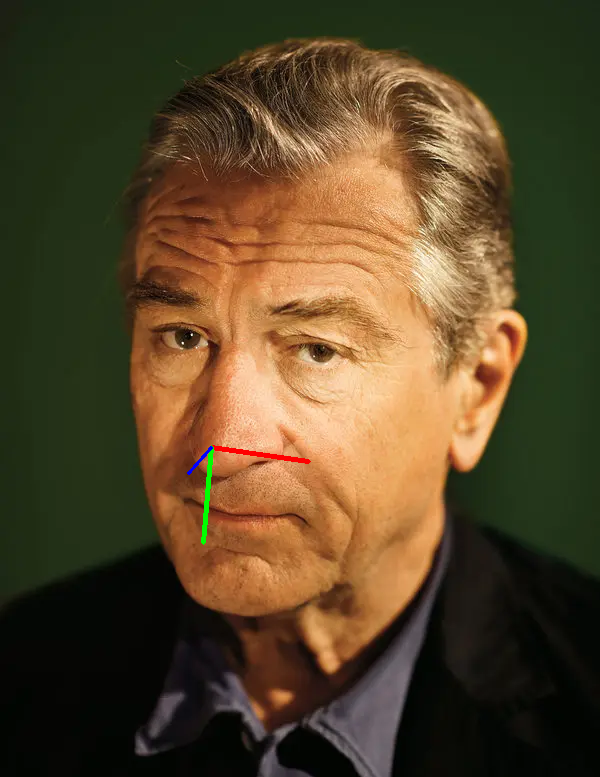

,X_0,Y_0,X_1,Y_1,X_2,Y_2,X_3,Y_3,X_4,Y_4,...,X_463,Y_463,X_464,Y_464,X_465,Y_465,X_466,Y_466,X_467,Y_467
0,0.114287,0.346916,0.008738,0.091837,0.10274,0.154312,-0.014873,-0.251673,0.0,0.0,...,0.494897,-0.537602,0.425205,-0.514019,0.375044,-0.491633,1.05621,-0.563655,1.11701,-0.590467


In [ ]:
import os
import cv2
import mediapipe as mp
import pandas as pd
import scipy.io as sio

image_path = '/content/test2.webp'

# Initialize face mesh module
mp_face_mesh = mp.solutions.face_mesh
faceModule = mp_face_mesh.FaceMesh(static_image_mode=True)

# Function to extract landmark points from an image
def extract_landmarks(image_path):
    # Load the image
    image = cv2.imread(image_path)#0
    if image is None:
        print(f"Error: Unable to read image {image_path}")
        return None

    # Process the face to extract landmark points
    results = faceModule.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    landmarks = []

    if results.multi_face_landmarks is not None:
        # Loop over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                landmarks.append((x, y))

        # Calculate noise
        x4, y4 = landmarks[4]
        noise = {'X4': x4, 'Y4': y4}

        # Calculate distance for normalization
        x152, y152 = landmarks[152]
        distance = math.sqrt((x4 - x152)**2 + (y4 - y152)**2)

        # Normalize landmarks
        normalized_landmarks = []
        for x, y in landmarks:
            normalized_x = (x - x4) / distance
            normalized_y = (y - y4) / distance
            normalized_landmarks.append((normalized_x, normalized_y))

        return normalized_landmarks, noise
    else:
        print(f"No face detected in {image_path}")
        return None, None

# Initialize an empty DataFrame
columns = ['Image']
for i in range(0,468):
  columns.extend([f"X_{i}",f"Y_{i}"])
data = pd.DataFrame(columns=columns + ['Noise_X4', 'Noise_Y4'])

# Iterate over all files in the directory
print(f"Processing image: {image_path}")
landmarks, noise = extract_landmarks(image_path)
if landmarks is not None:
    # Flatten the list of landmarks
    flattened_landmarks = [coord for landmark in landmarks for coord in landmark]

    # Append the image filename, landmarks, noise, and pose parameters to the DataFrame
    data = data.append({'Image': filename, **{f'X_{i}': coord[0] for i, coord in enumerate(landmarks)},
                            **{f'Y_{i}': coord[1] for i, coord in enumerate(landmarks)},
                            'Noise_X4': noise['X4'], 'Noise_Y4': noise['Y4']}, ignore_index=True)



image = cv2.imread(image_path)

noise_x = float(data.loc[:, 'Noise_X4']) * image.shape[1]
noise_y = float(data.loc[:, 'Noise_Y4']) * image.shape[0]
data = data.drop(columns = ['Image','Noise_X4','Noise_Y4'])
pitch = svr_model_pitch.predict(data)
yaw = svr_model_yaw.predict(data)
roll = svr_model_roll.predict(data)
# print(data[4,-3])
cv2_imshow(draw_axis(image,pitch,yaw,roll,noise_x,noise_y))


data

